# IOOS models


## Salinity horizontal slices

In [1]:
models = {
    'CNAPS':
    {
        'url': 'http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
    },
    'NECOFS':
    {
        'url': 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc',
    },
    'ESPRESSO':
    {
        'url': 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
    },
    'WCOFS':
    {
        'url': 'http://data.oceansmap.com/thredds/dodsC/EDS/WCOFS',
    },
    'OSU_ROMS':
    {
        'url': 'http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS',
    },
    'NYHOPS':
    {
        'url': 'http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/latest/Complete_gcmplt.nc',
    },
    'Columbia River':
    {
        'url': 'http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast.nc',
    },
    'WestCoastUCSC':
    {
        'url': 'http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd',
    },
}

In [2]:
var_names = [
    'sea_water_salinity',
    'sea_surface_salinity',
    'sea_water_absolute_salinity',
    'sea_water_practical_salinity',
    'model surface salinity',
    'salinity',
]

In [3]:
from gridgeo import GridGeo
from gridgeo.cfvariable import CFVariable

from netCDF4 import Dataset


def get_variable(nc):
    try:
        kwargs = {'standard_name': lambda v: v in var_names}
        var = CFVariable(nc, **kwargs)
        grid = GridGeo(nc, **kwargs)
    except ValueError:
        kwargs = {'long_name': lambda v: v in var_names}
        var = CFVariable(nc, **kwargs)
        grid = GridGeo(nc, **kwargs)
    return var, grid

In [4]:
for model, value in models.items():
    url = value['url']
    try:
        nc = Dataset(value['url'])
        var, grid = get_variable(nc)
    except (RuntimeError, ValueError) as e:
        print(f'Could not get data from {url}.html\n{e}')
    models[model].update({'nc': nc})
    models[model].update({'var': var})
    models[model].update({'grid': grid})

In [5]:
def get_surface_idx(var, mesh):
    # Short-circuit if data does not have a z-axis.
    if (('ugrid' not in mesh.lower() and var.ndim == 3) or
        ('ugrid' in mesh.lower() and var.ndim == 2)):
        return None

    z = var.z_axis()
    if np.argmin(z.shape) == 0 and z.ndim == 2:
        points = z[:, 0]
    elif np.argmin(z.shape) == 1 and z.ndim == 2:
        points = z[0, :]
    else:
        points = z[:]

    positive = getattr(z, 'positive', None)
    if positive == 'up':
        idx = np.unique(points.argmax(axis=0))[0]
    elif positive == 'down':
        idx = np.unique(points.argmin(axis=0))[0]
    else:
        raise ValueError(f'Cannot find property "positive" in {z}')
    return idx


def get_layer(var, mesh, layer, time_step=-1):
    if layer is None:
        return var[time_step, :]
    if var.ndim == 4 or 'ugrid' in mesh.lower():
        return var[time_step, layer, ...]
    elif var.ndim == 3 and 'ugrid' not in mesh.lower():
        return var[layer, ...]
    else:
        msg = "Cannot find the surface for var {!r}".format
        raise ValueError(msg(var))


def get_bbox(var, delta=0.1):
    x = var.x_axis()[:]
    y = var.y_axis()[:]
    return [
        np.min(x) - delta, np.max(x) + delta,
        np.min(y) - delta, np.max(y) + delta
    ]

In [6]:
%matplotlib inline

import cartopy.crs as ccrs
from cartopy.feature import COLORS, NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import numpy as np

from palettable.cmocean.sequential import Haline_20


cmap = Haline_20.mpl_colormap

LAND = NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=COLORS['land']
)


def plot_surface_cfvar(var, grid, name, vlevel=None, time_step=-1):
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw={'projection': ccrs.PlateCarree()},
    )
    ax.set_title(name)

    if name == 'NYHOPS':
        # This model is very wonky and the CF-model won't work here
        # b/c the coordinates associated with the temperature variable have NaNs
        # and we need to pull this x, y coordinates that are not listed in the variable.
        nc = model['nc']
        x, y = nc['x'][:], nc['y'][:]
    else:
        x = var.x_axis()[:]
        y = var.y_axis()[:]
    z = get_layer(var, grid.mesh, layer=vlevel, time_step=time_step)

    # Using masked data only to get `vmin` and `vmax`
    # b/c tripcolor cannot take masked data :-(
    # This workaround is need to plot the Columbia River data.
    # The mask info there is also flaky and that is why we are using 9.96921e+36.
    masked = np.ma.masked_greater_equal(z, 9.96921e+36)
    vmin, vmax = np.nanmin(masked), np.nanmax(masked)
    vmin = np.clip(vmin, 31, vmin)
    kw = {
        'cmap': cmap,
        'zorder': 0,
        'vmin': vmin,
        'vmax': vmax,
    }

    bbox = get_bbox(var)
    ax.set_extent(bbox)

    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.ylines = gl.xlines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.add_feature(LAND, zorder=1, edgecolor='black')

    if grid.mesh == 'ugrid':
        faces = grid.triang.triangles
        cs = ax.tripcolor(
            x, y, z,
            triangles=faces,
            **kw,
        )
    elif grid.mesh in ['sgrid', 'unknown_2d']:
        cs = ax.pcolormesh(x, y, z, **kw)

    units = getattr(var, 'units', 'None')
    standard_name = getattr(var, 'standard_name', 'None')
    if units in ['1', '1e-3', 'None']:
        units = r'g kg$^{-1}$'
    sal = {'sea_water_absolute_salinity': 'SA',
           'sea_water_practical_salinity': 'SP'}
    units = f'{units} {sal.get(standard_name, "")}'
    cbar = fig.colorbar(cs, extend='both', shrink=0.65)
    cbar.ax.set_title(units)
    return fig, ax

Processing model CNAPS...
Processing model NECOFS...
Processing model ESPRESSO...


/home/filipe/Dropbox/pymodules/01-forks/gridgeo/gridgeo/cfvariable.py:205: RuntimeWarning: invalid value encountered in greater
  return self._variable.__getitem__(key)


Processing model WCOFS...
Processing model OSU_ROMS...
Processing model NYHOPS...
Processing model Columbia River...
Processing model WestCoastUCSC...


/home/filipe/miniconda3/envs/IOOS/lib/python3.6/site-packages/matplotlib/colors.py:501: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


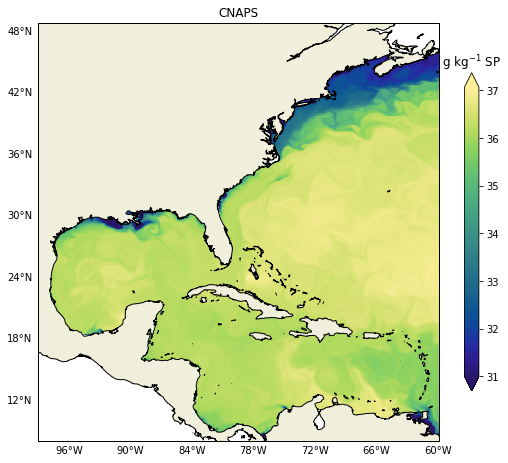

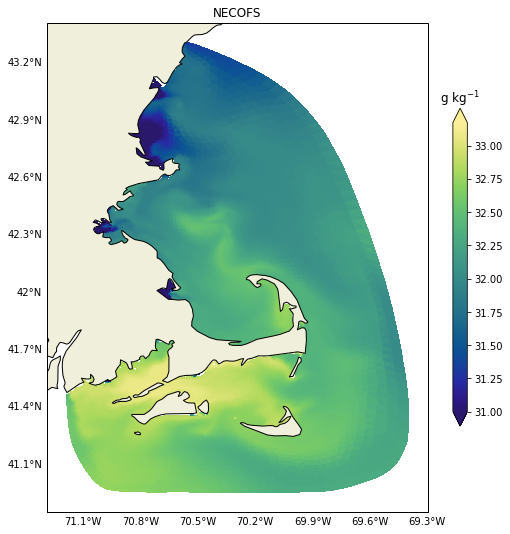

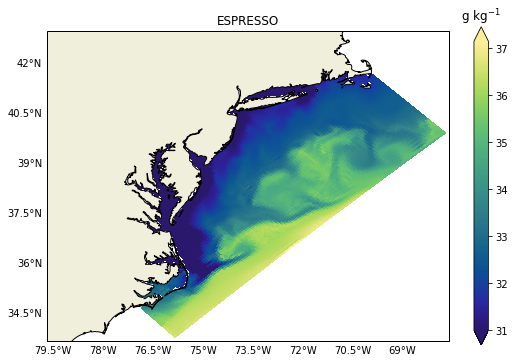

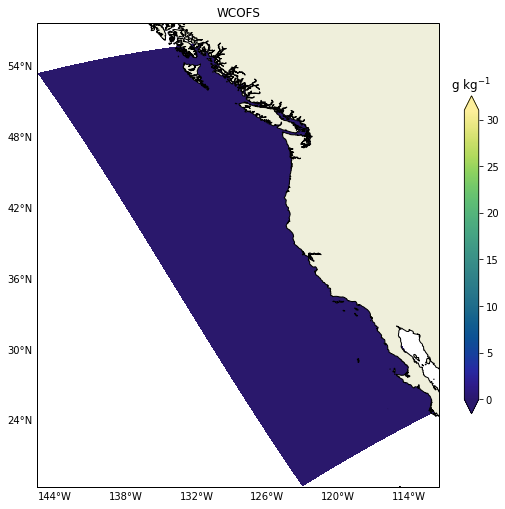

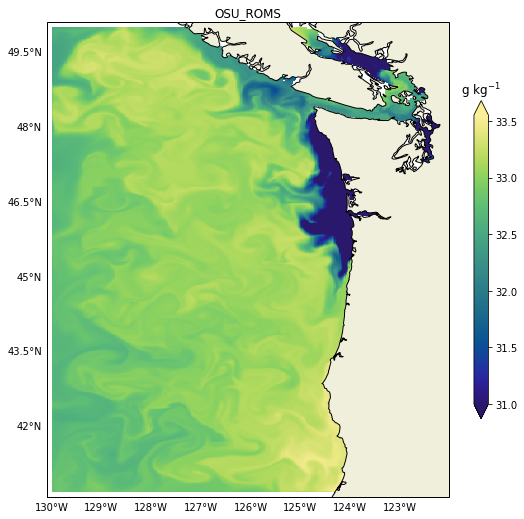

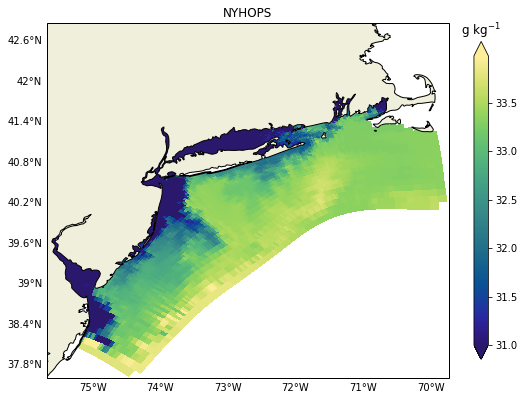

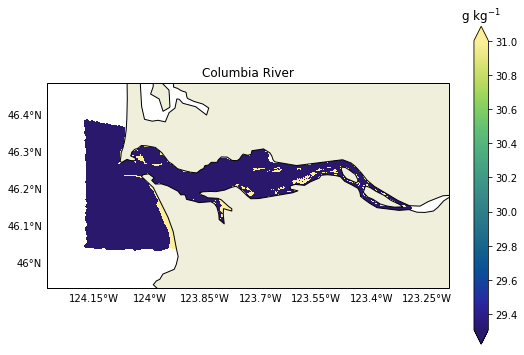

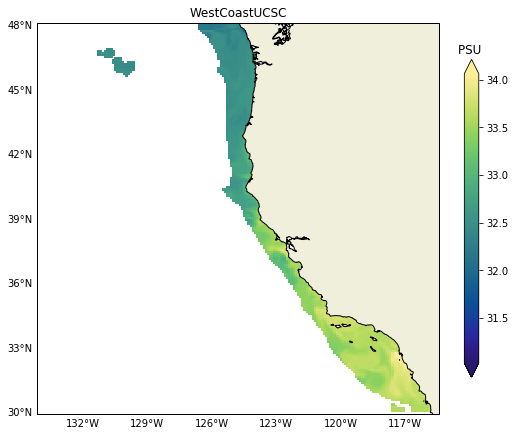

In [7]:
for name in models.keys():
    print(f'Processing model {name}...')
    model = models[name]
    grid = model['grid']
    var = model['var']
    vlevel = get_surface_idx(var, grid.mesh)
    fig, ax = plot_surface_cfvar(var, grid, name, vlevel=vlevel, time_step=-1)

`WestCoastUCSC` plot seems to be bottom temperatures and not surface.

See http://nbviewer.jupyter.org/gist/ocefpaf/efd6942d1794a71ed7dafd237ecee17f for some debug info.

/home/filipe/Dropbox/pymodules/01-forks/gridgeo/gridgeo/cfvariable.py:205: RuntimeWarning: invalid value encountered in greater
  return self._variable.__getitem__(key)


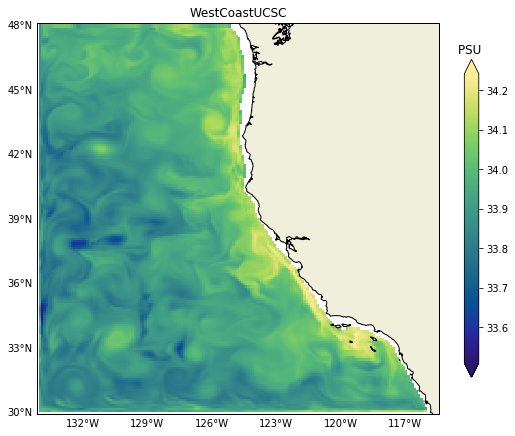

In [8]:
name = 'WestCoastUCSC'
model = models[name]
var = model['var']
grid = model['grid']

fig, ax = plot_surface_cfvar(var, grid, name, vlevel=0, time_step=-1)

`WCOFS` last time step has temperature values that are all zeroes,
here is the first time step.

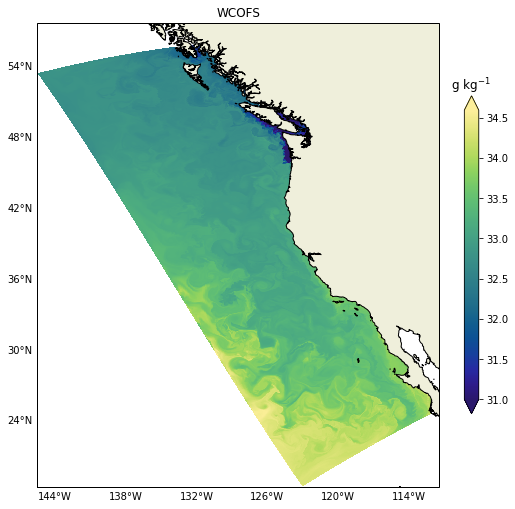

In [9]:
name = 'WCOFS'
model = models[name]
var = model['var']
grid = model['grid']

vlevel = get_surface_idx(var, grid.mesh)
fig, ax = plot_surface_cfvar(var, grid, name, vlevel=vlevel, time_step=0)